# Ribosome Profile Simulator

This script is used to create simulated ribosome profiles from scratch. The simulation works by drawing a set of elongation rates from a gamma distribution and then plugging those rates into the equations from the inhomogenous l-TASEP model in order to create estimations of ribosome density across the transcript. These distributions of ribosome density are then randomly sampled from in order to create the equivalent of 

### Step 1
Activate the Plastid conda environment and open up a Jupyter Lab session (alternatively, a python file can be run in this python environment)

### Step 2
Load in all of the necessary Python packages.

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Import necessary packages
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
from plastid.plotting.plots import *
import numpy as np
from Bio import SeqIO
import numpy
import math
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
import keegan_analysis_tools as kat
import TASEP_tools as tt
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import random
from matplotlib.pyplot import figure
from scipy.sparse.linalg import lsqr
from multiprocess import Pool
from tqdm import tqdm
from sympy import symbols, solve, sqrt

In [3]:
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'

### Step 3
Use a for-loop to run the simulate_profile() function multiple times to create a set of simulated count arrays. The parameters used to generate these simulations can be altered in several different ways depending on how we want to simulate the mutation. In this example, we are simulating 1 random pause per 100 codons with a pause strength that is equal to a reduction in elongation rate of 85%. The initiation rate is kept constant at 0.01 and the termination rate is kept very high at 2 in order to prevent termination limitation from occurring. Save our simulated count arrays along with the flux and phase of the simulations into lists. 

In [4]:
# Create a large number of simulations
data_control = []
j_control = []
phase_control = []
min_control = []
data_mutant = []
j_mutant = []
phase_mutant = []
min_mutant = []
for i in range(2400):
    length = numpy.random.randint(100,2500)
    alpha = 0.01
    # Add random noise to the read density, read density distribution similar to real data. 
    x = tt.simulate_profile(mean_lambda = 4, sd = 3, length = length, a= alpha, B = 2, min_read_density = 0.5, pause_density = 0.02, pause_str = 0.16, pause_area = 0.4,
                         a_frac = 1, elon_frac = 1, return_min_lam = True)
    data_control.append(x[0])
    j_control.append(x[1])
    phase_control.append(x[2])
    min_control.append(x[3])
    data_mutant.append(x[4])
    j_mutant.append(x[5])
    phase_mutant.append(x[6])
    min_mutant.append(x[7])

### Step 4
Smooth out the simulated count arrays using Loess smoothing and calculate the cumulative read distributions. This step can take some time so it is recommended to use the multiprocess.Pool() function to complete this using multiple cores. 

In [5]:
# Define the maximum number of processors that can be used when creating the smoothed vector arrays
max_pool = 20

# get smoothed vector arrays for all of the control data.
with Pool(max_pool) as p:
    pool_control = list(
         tqdm(
            p.imap(kat.get_smoothed_vector,
                      data_control),
            total=len(data_control)
        )
    )    

100%|███████████████████████████████████████| 2400/2400 [00:29<00:00, 81.00it/s]


In [6]:
# get smoothed vector arrays for all of the mutant data.
with Pool(max_pool) as p:
    pool_mutant = list(
        tqdm(
            p.imap(kat.get_smoothed_vector,
                       data_mutant),
            total=len(data_mutant)
        )
    )    

100%|███████████████████████████████████████| 2400/2400 [00:30<00:00, 79.73it/s]


## Determine KS statistic for all transcripts

### Step 5
For each gene in your simulated mutant and control samples, calculate the KS-statistic as the maximum distance between their cumulative distributions and then save this KS-statistic as a list. 

In [7]:
# Define your lists
ks_list = []
len_list = []
id_list = []

# Create a variable named x and set it to -1. We will add 1 to x for each iteration of the for loop so we can keep track of the for loop iteration.
x = -1

# Calculate the KS statistic for each example and fill up our lists.
for tr_m, tr_c, index in zip(data_mutant, data_control, list(range(len(data_mutant)))):
    x = x+1
    position = np.array(list(range(len(tr_m))))
    smoothed_vec_m, cumul_m = pool_mutant[index]
    smoothed_vec_c, cumul_c = pool_control[index]
    ks = max(abs(cumul_m - cumul_c))
    ks_list.append(ks)
    len_list.append(len(tr_m))
    id_list.append(x)

### Step 6
Combine the lists for the gene IDs, gene lengths, fluxes, phases, and KS statistics into a pandas dataframe using the pd.DataFrame, list() & zip() functions. 

In [8]:
# reorganizing the lists into a dataframe. 
df_b = pd.DataFrame(list(zip(ks_list, j_control, j_mutant, phase_control, phase_mutant, min_control, min_mutant, len_list, id_list)))
df_b.columns = ["ks_stat","J_control", "J_mutant","phase_control", "phase_mutant","min_control", "min_mutant", "gene_length", "id"]

### Step 7
sort your newly made dataframe from the lowest KS statistic to the highest KS statistic using \newline \verb|df.sorted()|

In [9]:
# Sort all of the values by the KS statistic. 
df_sorted = df_b.sort_values(by = "ks_stat")

### Step 8
Create a list called colours which will contain a colour based on the phase that was used for the mutant in the simulation. Save this list as a new column on our dataframe. 

In [10]:
# Create new columns which record a different colour, size, and point shape depending on the phase of the simulated sample. 
colours = []
sizes = []
shapes = []
for i in df_sorted.phase_mutant:
    if i == "MC":
        colours.append("magenta")
        sizes.append(100)
        shapes.append('None')
    elif i == "LD":
        colours.append("g")
        sizes.append(12)
        shapes.append("g")
    elif i == "HD":
        colours.append("b")
        sizes.append(50)
        shapes.append("none")
df_sorted["colours"] = colours
df_sorted["sizes"] = sizes
df_sorted["shapes"] = shapes

### Step 9
Use a scatterplot to view the KS statistic from all of the control-mutant comparisons to see if the mutants that were simulated as being elongation limited (MC) have higher KS statistics than the other comparisons. The points of this scatterplot will be colour coded based on the colours column of your dataframe. You should be able to see a clear separation between the samples where the mutation induced elongation limitation and the samples where where the mutation only induced some strong pauses. 

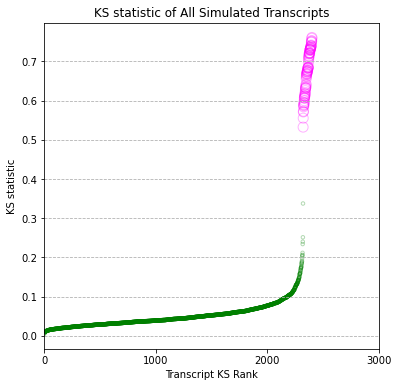

In [11]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (6,6))
plt.scatter(list(range(len(df_sorted.ks_stat))), df_sorted.ks_stat, s = df_sorted.sizes, alpha = 0.3, facecolors = "none", edgecolors= df_sorted.colours)
plt.ylabel("KS statistic")
plt.xlabel("Transcript KS Rank")
plt.title("KS statistic of All Simulated Transcripts")
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.xlim(0,3000)
plt.locator_params(axis="x", nbins=4)
plt.savefig(image_path + 'colour_coded_simulation.pdf')

In [12]:
df_b.sort_values(by = "ks_stat")

ks_stat  J_control  J_mutant phase_control phase_mutant  min_control  \
2121  0.004822   0.009784  0.009784            LD           LD     0.916346   
874   0.006199   0.009197  0.009197            LD           LD     0.973785   
933   0.007800   0.009364  0.009364            LD           LD     0.926263   
464   0.008218   0.009421  0.009421            LD           LD     0.873721   
752   0.009189   0.009844  0.009844            LD           LD     1.058093   
...        ...        ...       ...           ...          ...          ...   
1469  0.749670   0.009792  0.007502            LD           MC     0.812286   
577   0.751521   0.009864  0.008533            LD           MC     0.923901   
2236  0.752823   0.009848  0.009516            LD           MC     0.951081   
2097  0.758759   0.009931  0.009168            LD           MC     0.880882   
2226  0.760902   0.009884  0.008168            LD           MC     0.884388   

      min_mutant  gene_length    id  
2121    0.458550         1281  2121  
874     0.465911         2439   874  
933     0.383341         1516   933  
464     0.267053         1690   464  
752     0.550270         1151   752  
...          ...          ...   ...  
1469    0.129966         1695  1469  
577     0.147824         2392   577  
2236    0.164869         1486  2236  
2097    0.158823         2163  2097  
2226    0.141502         1647  2226  

[2400 rows x 9 columns]

In [13]:
# Find all of the transcripts with a KS stat above a certain threshold and group them by gene ID
group = df_b[(df_b['ks_stat'] > 0.19)].groupby('id')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [14]:
# Look at the number of genes in your list so you can avoid creating an absurd number of graphs. 
len(diff_dist)

90

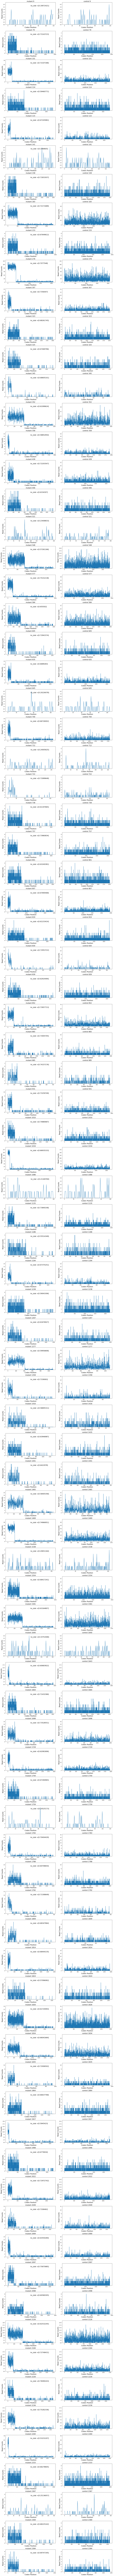

In [15]:
# Look at the smoothed count distributions for each of the transcripts that passed the threshold
ax = tt.big_dif_sim(diff_dist, data_mutant, data_control, figsize = (16,len(diff_dist)*4), fontsize = 16)

Text(0, 0.5, 'KS Statistic')

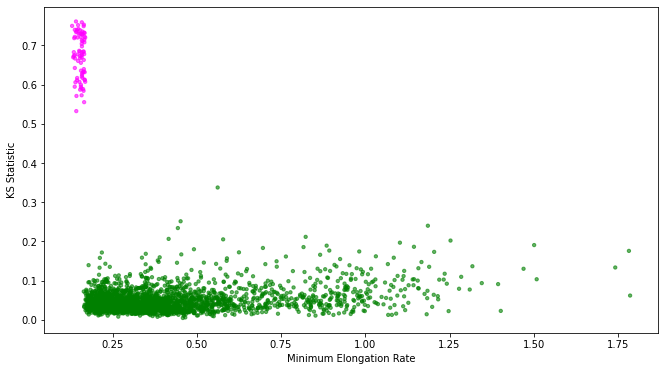

In [16]:
# Create a figure showing the relationship between the KS statistic and the minimum elongation rate. 
figure(figsize = (11,6))
plt.scatter(df_sorted.min_mutant, df_sorted.ks_stat, c = df_sorted.colours, s=11, alpha = 0.6)
plt.xlabel("Minimum Elongation Rate")
plt.ylabel("KS Statistic")

## Choose a simulated gene of interest and observe the smooth and unsmooth array.

In [17]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_vec_mutant = data_mutant[735]
my_vec_control = data_control[735]

In [18]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_vec_control+0.00000000001)

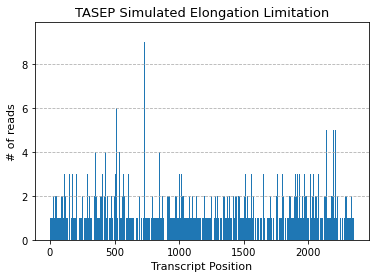

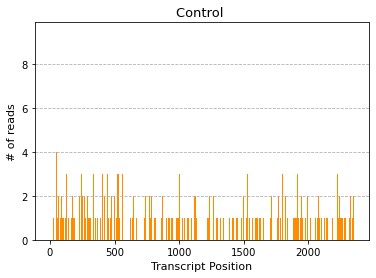

In [19]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.bar(list(range(len(my_vec_mutant))),my_vec_mutant, width = 4)
plt.ylim([0,maxi*1.1])
plt.ylabel("# of reads", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("TASEP Simulated Elongation Limitation", fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + 'simulated_MC_array.pdf')
plt.show()
plt.bar(list(range(len(my_vec_mutant))), my_vec_control, color = "darkorange", width = 1.4)
plt.ylim([0,maxi*1.1])
plt.ylabel("# of reads", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Control ", fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
#plt.savefig(image_path + my_gene + '_control_array.pdf')

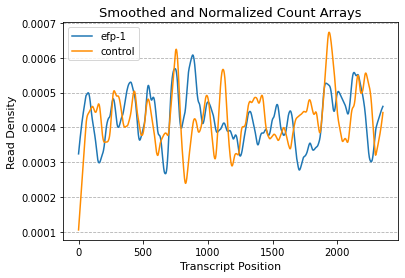

In [20]:
plt.plot(smoothed_vec_m, label = "efp-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "control", color = "darkorange")
plt.ylabel("Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Smoothed and Normalized Count Arrays", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
#plt.savefig(image_path + my_gene +'_smoothed.pdf')

In [21]:
ks = max(abs(cumul_m - cumul_c))

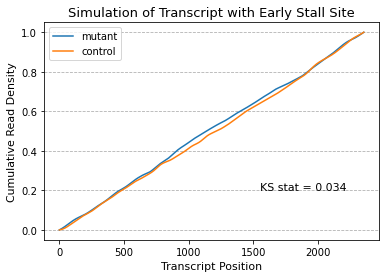

In [22]:
plt.plot(cumul_m, label = "mutant")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(cumul_c, label = "control")
plt.text(len(cumul_m)*0.66, 0.2, "KS stat = " + str(round(ks,3)), fontsize = 11)
plt.ylabel("Cumulative Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Simulation of Transcript with Early Stall Site", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + 'Early_stall_site_cumulative.pdf')